In [182]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from collections import Counter
from sklearn.impute import KNNImputer
import os, gc

pd.set_option('display.max_columns', None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Functions

In [183]:
def convert_pixels(data):
    data = np.array([row.split(' ') for row in data['Image']],dtype='float') / 255.0
    data = data.reshape(-1,96,96,1)
    return(data)

In [184]:
def view_img(sample_img):
    plt.figure()
    plt.imshow(sample_img.reshape(96,96),cmap='gray')
    plt.show()

## Import data

In [185]:
train_file = '../input/training/training.csv'
test_file = '../input/test/test.csv'
train_data = pd.read_csv(train_file)  
test_data = pd.read_csv(test_file)

In [186]:
y_train = train_data[[col for col in train_data.columns if col != 'Image']].to_numpy()

In [187]:
x_train = convert_pixels(train_data)
x_test = convert_pixels(test_data)

## EDA  
**labels**
1. [ ] Explore imputation strategies
    - Completed code. Will require running entire model
    - Perhaps take a look at images that have missing values to determine if there are inherent reasons why this is not valid.
    - Create a summary slide of common reasons why things are not labeled.
2. [ ] Explore outlier correction strategies to identify if areas of the face are mislabeled
**image**  
1. [ ] Add noise via rotation, flipped image, blurring, etc.  
2. [x] Explore imputation strategies
    - There are no missing pixels in the training or testing images.
**overall**  
1. [ ] Update to RMSE scoring
2. [ ] Add code to troubleshoot the most wrongly predicted images to identify images causing large sources of error

### Explore NA in labels
Based on the below analysis, distributions are fairly normal with some outliers, and mean and median are fairly similar.


Number of columns with any NA value:


True     28
False     3
dtype: int64


Number of images missing coordinates for each feature:


left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_bottom_lip_y      33
dtype: int64


Test skew of each distribution:


[('left_eye_center_x', 'Not normal'),
 ('left_eye_center_y', 'Not normal'),
 ('right_eye_center_x', 'Not normal'),
 ('right_eye_center_y', 'Not normal'),
 ('left_eye_inner_corner_x', 'Not normal'),
 ('left_eye_inner_corner_y', 'Not normal'),
 ('left_eye_outer_corner_x', 'Not normal'),
 ('left_eye_outer_corner_y', 'Not normal'),
 ('right_eye_inner_corner_x', 'Not normal'),
 ('right_eye_inner_corner_y', 'Not normal'),
 ('right_eye_outer_corner_x', 'Not normal'),
 ('right_eye_outer_corner_y', 'Not normal'),
 ('left_eyebrow_inner_end_x', 'Not normal'),
 ('left_eyebrow_inner_end_y', 'Not normal'),
 ('left_eyebrow_outer_end_x', 'Not normal'),
 ('left_eyebrow_outer_end_y', 'Not normal'),
 ('right_eyebrow_inner_end_x', 'Not normal'),
 ('right_eyebrow_inner_end_y', 'Not normal'),
 ('right_eyebrow_outer_end_x', 'Not normal'),
 ('right_eyebrow_outer_end_y', 'Not normal'),
 ('mouth_left_corner_x', 'Not normal'),
 ('mouth_left_corner_y', 'Not normal'),
 ('mouth_right_corner_x', 'Normal'),
 ('mouth_


Compare mean and median of these distribution:


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,22.535954,37.867071,56.244975,29.528872,79.784229,29.773813,39.298848,29.569347,15.785709,30.320160,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326


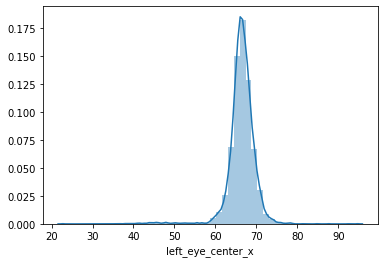

In [196]:
print('\nNumber of columns with any NA value:')
train_data.isnull().any().value_counts()
columns_nan = train_data.columns[train_data.isna().any()].tolist()

print('\nNumber of images missing coordinates for each feature:')
train_data[columns_nan].isna().sum(axis=0)

print('\nTest skew of each distribution:')
[(col,['Not normal' if stats.skewtest(train_data[col],nan_policy='omit').pvalue < .05 else 'Normal'][0]) for col in columns_nan]

print('\nCompare mean and median of these distribution:')
train_data.describe().loc[['mean','50%']]
sns.distplot(train_data[columns_nan[0]])

In [195]:
# print('\n========== Show training images ==========')
# for el in range(5):
#     view_img(x_train[el])


Use Nearest Neighbors imputation. Takes closest 3 neighbors with the most important neighbor being the closest neighbor (`weights='distance' vs weights='uniform'`).

In [190]:
imputer = KNNImputer(n_neighbors=3, weights='distance')
y_train = imputer.fit_transform(y_train)

Compare imputed value with the actual image


========== Assessing missing feature: left_eye_center ==========


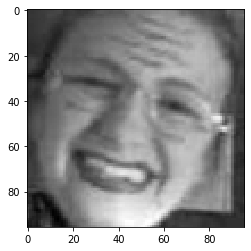

Imputed left_eye_center coordinates for image 1687:[66.58040658 41.83346233]



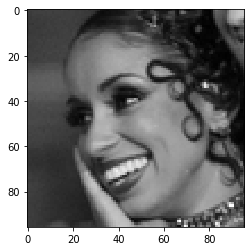

Imputed left_eye_center coordinates for image 1834:[45.49592516 40.17527771]



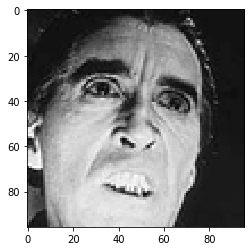

Imputed left_eye_center coordinates for image 1866:[64.00315521 38.0433079 ]



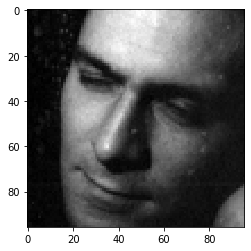

Imputed left_eye_center coordinates for image 1938:[60.02280181 40.76183874]



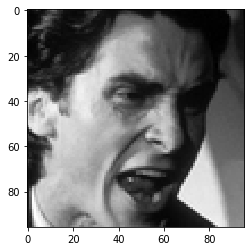

Imputed left_eye_center coordinates for image 2100:[72.01329043 43.97853653]



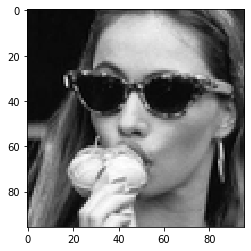

Imputed left_eye_center coordinates for image 2137:[65.92574717 37.26274557]



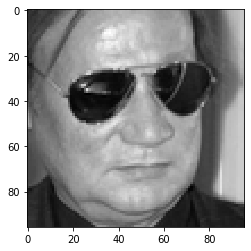

Imputed left_eye_center coordinates for image 2153:[64.89800213 34.56680064]



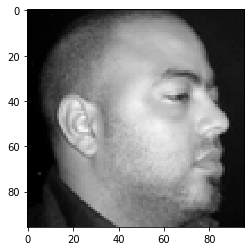

Imputed left_eye_center coordinates for image 2175:[73.74335839 33.85831103]



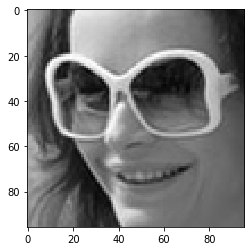

Imputed left_eye_center coordinates for image 2186:[65.46654424 35.99301617]



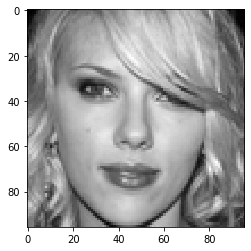

Imputed left_eye_center coordinates for image 2239:[65.87124773 36.75925064]


========== Assessing missing feature: mouth_center_top_lip ==========


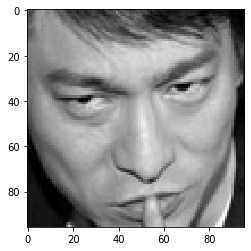

Imputed mouth_center_top_lip coordinates for image 1724:[51.33383851 86.97206171]



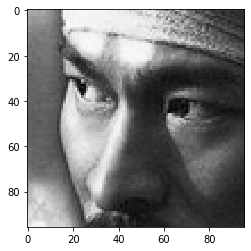

Imputed mouth_center_top_lip coordinates for image 1731:[40.76993096 84.82873883]



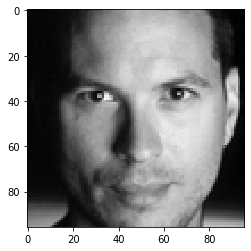

Imputed mouth_center_top_lip coordinates for image 1747:[51.56309922 84.68883264]



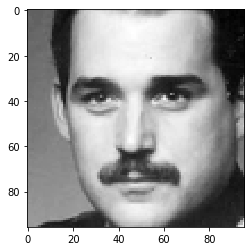

Imputed mouth_center_top_lip coordinates for image 1877:[59.56141973 85.71581562]



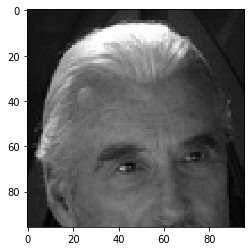

Imputed mouth_center_top_lip coordinates for image 1881:[55.85473399 89.94180443]



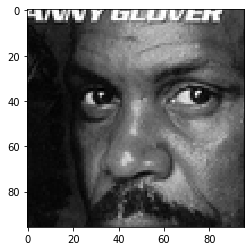

Imputed mouth_center_top_lip coordinates for image 1979:[50.6405062  85.91735476]



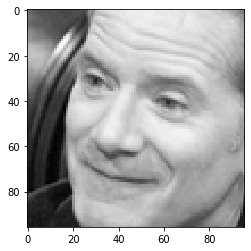

Imputed mouth_center_top_lip coordinates for image 2060:[36.54832476 73.32212723]



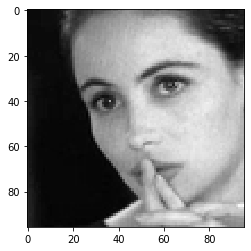

Imputed mouth_center_top_lip coordinates for image 2125:[55.76854591 72.09474295]



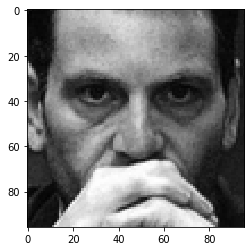

Imputed mouth_center_top_lip coordinates for image 2154:[48.33015382 76.49300697]



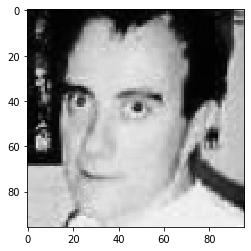

Imputed mouth_center_top_lip coordinates for image 2284:[34.79325755 74.31327956]



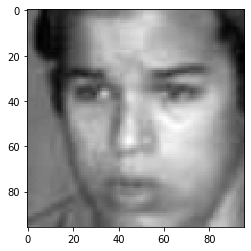

Imputed mouth_center_top_lip coordinates for image 2285:[47.0895916  73.83347928]

Too many images missing coordinates. Only printing 10.


In [191]:
def missing_coord(feature:str):
    """
    Compare missing labels for a specific feature with the imputed values.
    input:
        - feature: str. a facial keypoint we'd like to explore
    """
    print(f'\n========== Assessing missing feature: {feature} ==========')
    x_coord = feature + '_x'
    y_coord = feature + '_y'
    missing_feature = train_data.loc[(train_data[x_coord].isnull()) | (train_data[y_coord].isnull()),
                                 [x_coord,y_coord]]
    num_col = [ind for ind,el in 
               enumerate(train_data.columns.isin([x_coord,y_coord])) if el==True]

    for enum_ind,ind in enumerate(missing_feature.index):
        if enum_ind > 10: print('Too many images missing coordinates. Only printing 10.'); break
        view_img(x_train[ind])
        print(f'Imputed {feature} coordinates for image {ind}:{y_train[ind][num_col]}\n')

# missing_coord('right_eye_center')
missing_coord('left_eye_center')
missing_coord('mouth_center_top_lip')

### Explore NA in images
There are no missing pixels in the training or testing images.

In [192]:
img = [set(row.split(' ')) for row in train_data['Image']]
['' in row for row in img].count(True)

0

In [193]:
img = [set(row.split(' ')) for row in test_data['Image']]
['' in row for row in img].count(True)

0